
# SES / ES Bearing Fault Analysis – Example Pipeline

This notebook demonstrates the Python pipeline for uncertainty-induced parameters in envelope analysis
using rolling element bearings. It follows these steps:

1. Load data from an Excel file (X, Y or Z axis).
2. Visualise raw signal, rectified signal, and Hilbert envelope.
3. Compute SES/ES for full and segmented signals.
4. Compare Hilbert vs rectification, and band vs no-band BPFO selection.
5. Zoom around BPFO.
6. Study NFFT effects on 1x and 2x BPFO amplitudes.
7. Construct convex hulls in the (1xBPFO, 2xBPFO) plane.

Run each cell in order and edit the configuration cell where indicated
to point to your own dataset.


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import os
from scipy.io import loadmat



from ses_core import (
    ses,
    compute_BPFO_SNR,
    analyse_ses,
    convexhull,
    load_excel_signal,
)

# Global plotting style (can be adjusted)
MEDIUM_SIZE = 12

plt.rc("font", size=MEDIUM_SIZE)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)
plt.rc("figure", titlesize=MEDIUM_SIZE)
plt.rc("figure", figsize=(6, 4), dpi=150)
plt.rc("lines", linewidth=0.2)
plt.rc("savefig", dpi=300, format="pdf")
plt.rc("grid", linestyle="--")
plt.rcParams["axes.formatter.use_mathtext"] = True

matplotlib.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.unicode_minus": False,
    }
)

print("Imports and plotting style configured.")


Imports and plotting style configured.


## 1. Configuration – paths, sampling, and BPFO

In [4]:

# === User configuration ===
# Edit this cell to point to your data and bearing parameters.

cases = ['Baseline', 'Visual', 'No Outerrace', 'Outerrace']
test_number = 2
case_number = cases[0]
record_number = 1
condition = 'Damage'

excel_path = f"C:/Users/User/OneDrive - University of Pretoria/Desktop/EBIT_Masters/Data/Bearing_Orig_data/{condition}/Test {test_number}/{case_number}/Test {record_number}.xlsx"  # TODO: replace with your file path
axis = "X"                                # 'X', 'Y' or 'Z'

# excel_path = f'C:/Users/User/OneDrive - University of Pretoria/Desktop/EBIT_Masters/Analysis/Vibration/Revised/

fs = 48_000.0                             # sampling frequency [Hz]
duration = 10.0                           # seconds to analyse

# Example: BPFO from the bearing geometry & speed
bpfo = 276.27                             # [Hz]
bpfo_list = [bpfo, 2 * bpfo]              # 1x and 2x BPFO
bpfo_list_env = [bpfo, 2 * bpfo, 3 * bpfo]

segment_sec = 1.0                         # 1 s segments

print("Configuration set. Now run the next cell to load data.")


Configuration set. Now run the next cell to load data.


## 2. Load data from Excel

In [6]:
t, Raw_signal, speed = load_excel_signal(
    filepath=excel_path,
    axis=axis,
    fs=fs,
    duration=duration,
    header_rows_to_skip=48,
)

# Clean NaNs/Infs right after loading
Raw_signal = np.nan_to_num(Raw_signal, nan=0.0, posinf=0.0, neginf=0.0)
print(f"Loaded signal with {len(Raw_signal)} samples, axis={axis}, fs={fs} Hz.")



Loaded signal with 480000 samples, axis=X, fs=48000.0 Hz.


## 3. Visualise raw, rectified, and Hilbert-demodulated signals

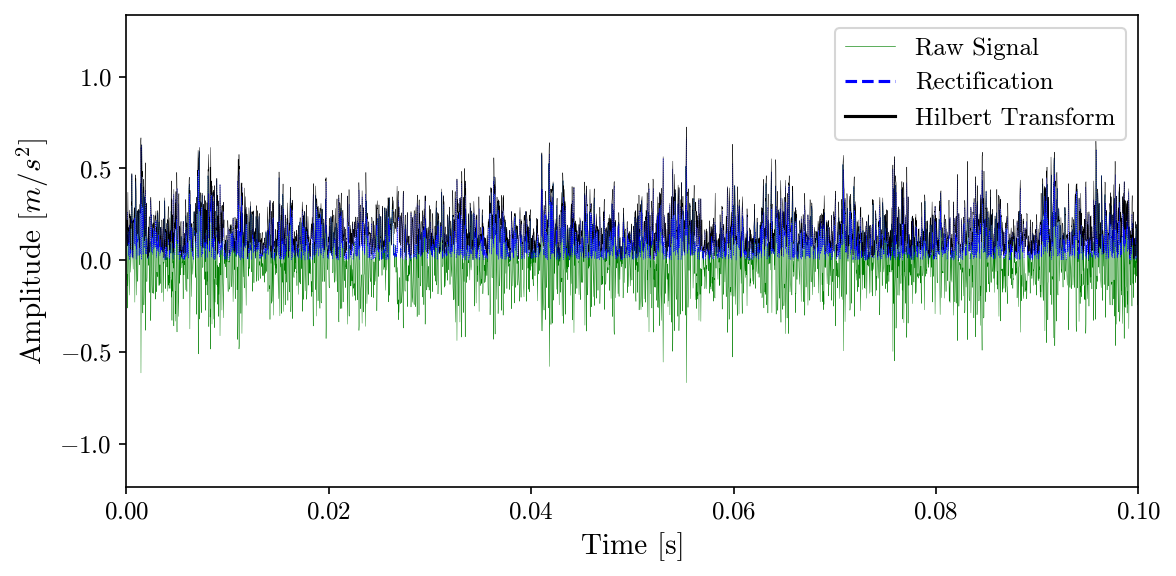

In [8]:

from scipy.signal import hilbert

plt.figure(figsize=(8, 4))
plt.plot(t, Raw_signal, "g", label="Raw Signal")
plt.plot(t, np.abs(Raw_signal), "b--", label="Rectification")
plt.plot(t, np.abs(hilbert(Raw_signal)), "k", label="Hilbert Transform")

legend_handles = [
    Line2D([0], [0], color="g", lw=0.3, label="Raw Signal"),
    Line2D([0], [0], color="b", lw=1.5, ls="--", label="Rectification"),
    Line2D([0], [0], color="k", lw=1.5, label="Hilbert Transform"),
]

plt.legend(handles=legend_handles,loc='upper right')
plt.ylabel(r"Amplitude [$m/s^2$]")
plt.xlabel("Time [s]")
plt.xlim(0, 0.1)  # first 0.1 s for clarity
plt.tight_layout()
plt.show()


## 4. SES / ES for full vs segmented signals

In [10]:

p_type = "SES"     # 'SES' or 'ES'
band = True        # True -> ±1 Hz band around BPFO, False -> exact bin
band_select = "band" if band else "no_band"

y1 = Raw_signal

y1_seg = Raw_signal[: int(fs * segment_sec)]  # first 1 s segment

nfft_full = len(y1)
nfft_seg = len(y1_seg)

freq_full = np.arange(nfft_full // 2) * (fs / nfft_full)
freq_seg = np.arange(nfft_seg // 2) * (fs / nfft_seg)

# SES/ES results
ses_idx1, idx1, ses1 = ses(y1, nfft_full, fs, bpfo_list_env, hilb="f", p_type=p_type,bw=5, band=band)
ses_idx1_hilbert, idx1_hilbert, ses1_hilbert = ses(y1, nfft_full, fs, bpfo_list_env, hilb="t", p_type=p_type, bw=5, band=band)

ses_idx1_seg, idx1_seg, ses1_seg = ses(y1_seg, nfft_seg, fs, bpfo_list_env, hilb="f", p_type=p_type,bw=5, band=band)
ses_idx1_seg_hilbert, idx1_seg_hilbert, ses1_seg_hilbert = ses(y1_seg, nfft_seg, fs, bpfo_list_env, hilb="t", p_type=p_type, bw=5, band=band)

print("Computed SES/ES for full and segmented signals.")


Computed SES/ES for full and segmented signals.


### 4.1 Full signal SES / ES

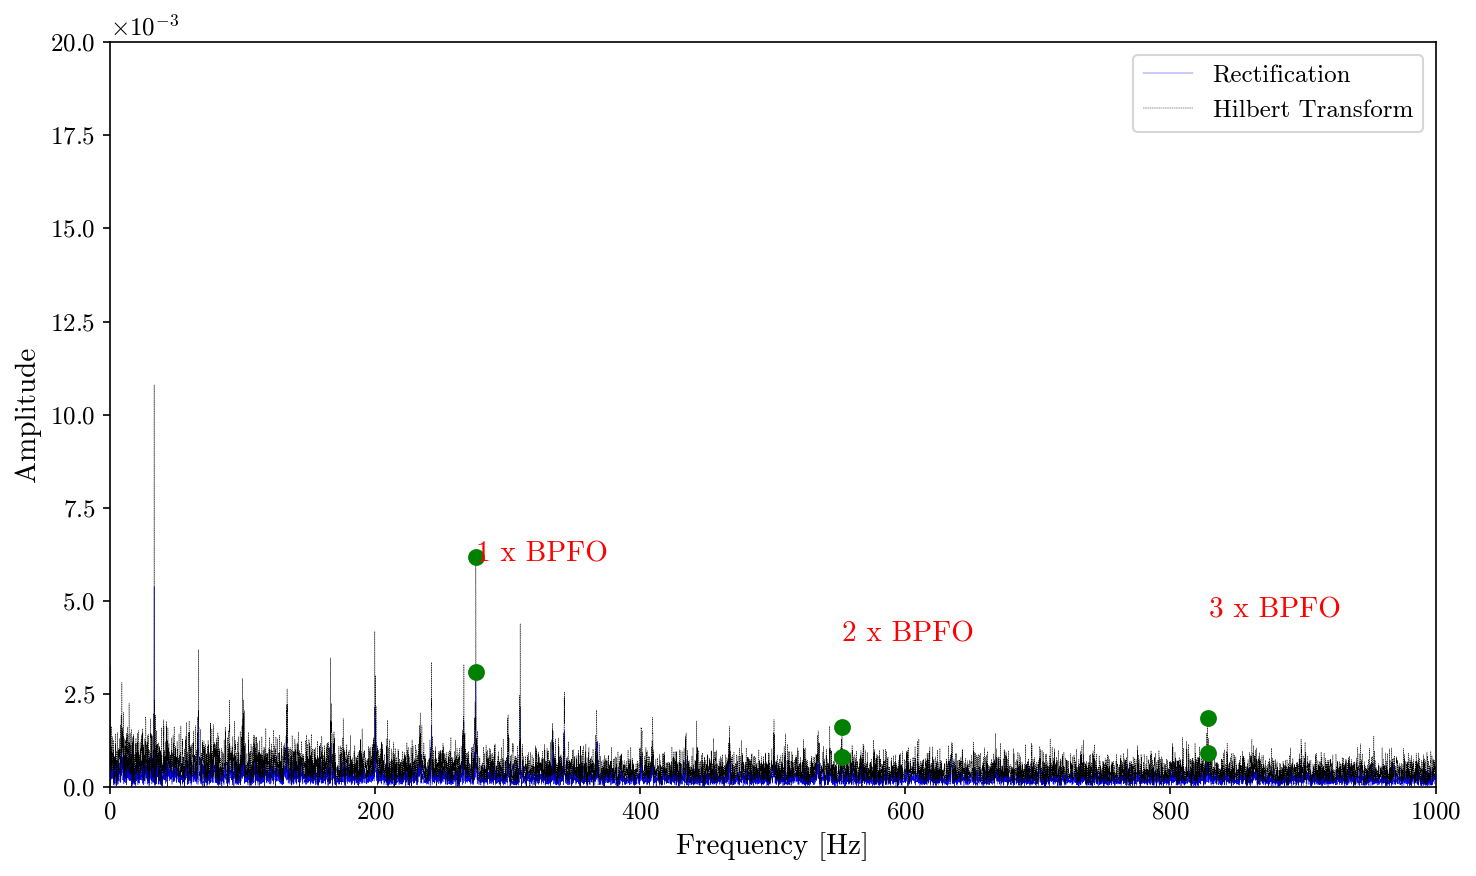

In [12]:

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, -3))
formatter.set_scientific(True)

es_diff = 0.002  # small offset for annotations

fig1, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(freq_full, ses1[: len(freq_full)], label="Rectification", color="blue")
ax1.plot(freq_full, ses1_hilbert[: len(freq_full)], label="Hilbert Transform", color="black", linestyle="dashed")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_xlim(0, 1000)
ax1.set_ylim(0, 20e-3)

# Markers at band-based peaks (if band=True)
for idx, amp in zip(idx1, ses_idx1):
    if idx >= 0:
        ax1.scatter(freq_full[idx], amp, color="green", s=50, zorder=2)

for idx, amp in zip(idx1_hilbert, ses_idx1_hilbert):
    if idx >= 0:
        ax1.scatter(freq_full[idx], amp, color="green", s=50, zorder=2)

# BPFO annotations (based on Hilbert spectrum)
ax1.text(
    bpfo_list_env[0],
    ses1_hilbert[np.abs(freq_full - bpfo_list_env[0]).argmin()] + 0.003 + es_diff,
    "1 x BPFO",
    color="red",
    fontsize=14,
    ha="left",
    va="bottom",
)
ax1.text(
    bpfo_list_env[1],
    ses1_hilbert[np.abs(freq_full - bpfo_list_env[1]).argmin()] + 0.001 + es_diff,
    "2 x BPFO",
    color="red",
    fontsize=14,
    ha="left",
    va="bottom",
)
ax1.text(
    bpfo_list_env[2],
    ses1_hilbert[np.abs(freq_full - bpfo_list_env[2]).argmin()] + 0.002 + es_diff,
    "3 x BPFO",
    color="red",
    fontsize=14,
    ha="left",
    va="bottom",
)

ax1.yaxis.set_major_formatter(formatter)
ax1.legend(loc="upper right")
fig1.tight_layout()
plt.show()


### 4.2 Segmented signal SES / ES

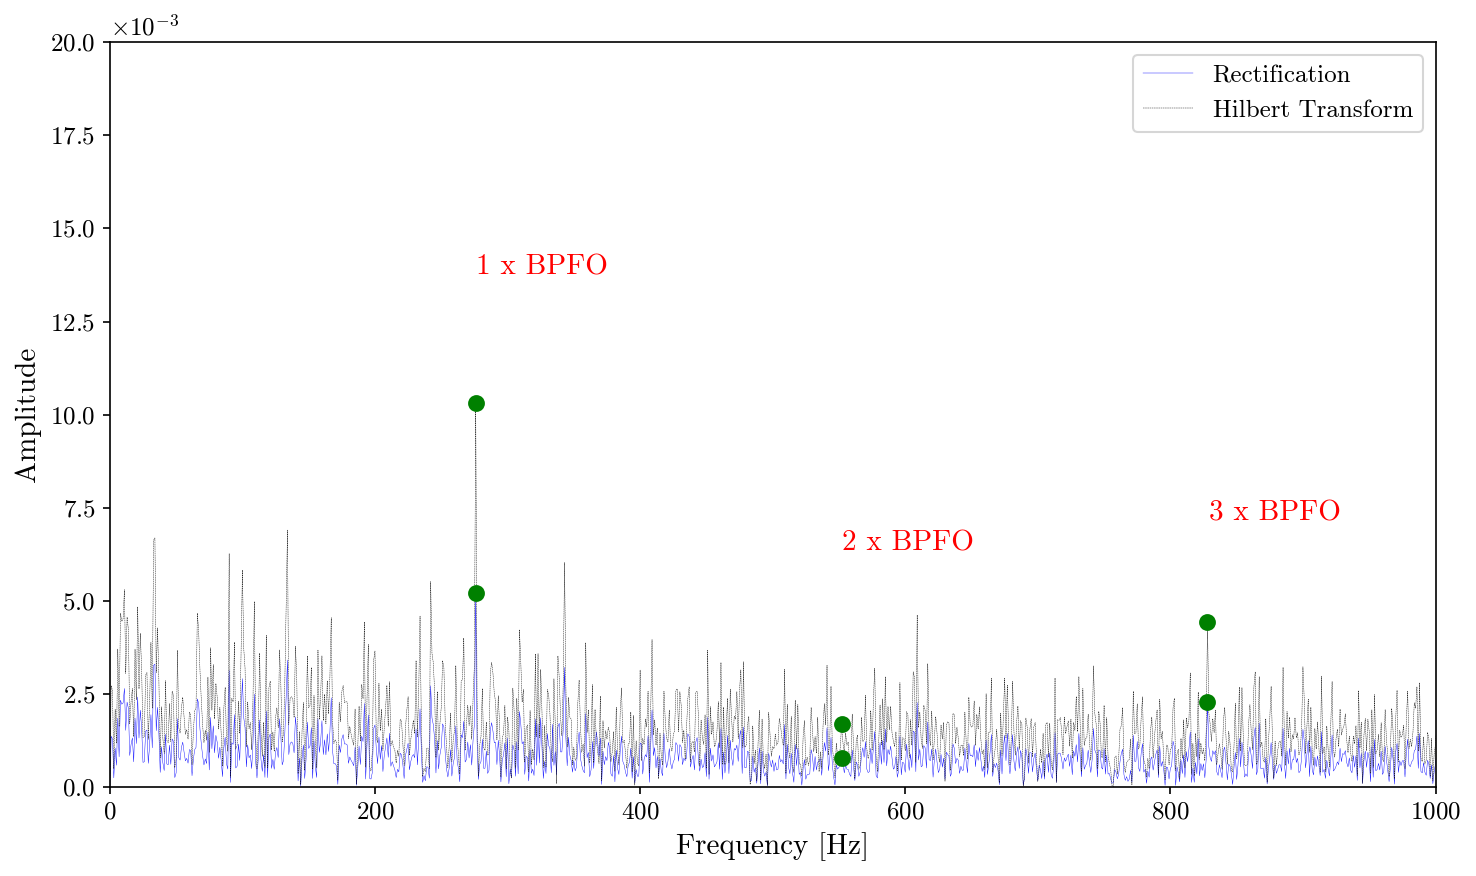

In [14]:

f_diff = 0.002

fig2, ax2 = plt.subplots(figsize=(10, 6))

ax2.plot(freq_seg, ses1_seg[: len(freq_seg)], label="Rectification", color="blue")
ax2.plot(freq_seg, ses1_seg_hilbert[: len(freq_seg)], label="Hilbert Transform", color="black", linestyle="dashed")
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 20e-3)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Amplitude")

for idx, amp in zip(idx1_seg, ses_idx1_seg):
    if idx >= 0:
        ax2.scatter(freq_seg[idx], amp, color="green", s=50, zorder=2)

for idx, amp in zip(idx1_seg_hilbert, ses_idx1_seg_hilbert):
    if idx >= 0:
        ax2.scatter(freq_seg[idx], amp, color="green", s=50, zorder=2)

ax2.text(
    bpfo_list_env[0],
    ses1_seg_hilbert[np.abs(freq_seg - bpfo_list_env[0]).argmin()] + 0.002 + f_diff,
    "1 x BPFO",
    color="red",
    fontsize=14,
    ha="left",
    va="top",
)
ax2.text(
    bpfo_list_env[1],
    ses1_seg_hilbert[np.abs(freq_seg - bpfo_list_env[1]).argmin()] + 0.003 + f_diff,
    "2 x BPFO",
    color="red",
    fontsize=14,
    ha="left",
    va="bottom",
)
ax2.text(
    bpfo_list_env[2],
    ses1_seg_hilbert[np.abs(freq_seg - bpfo_list_env[2]).argmin()] + 0.003 + f_diff,
    "3 x BPFO",
    color="red",
    fontsize=14,
    ha="left",
    va="bottom",
)

ax2.yaxis.set_major_formatter(formatter)
ax2.legend(loc="upper right")
fig2.tight_layout()
plt.show()


## 5. Zoom around BPFO (full vs segmented)

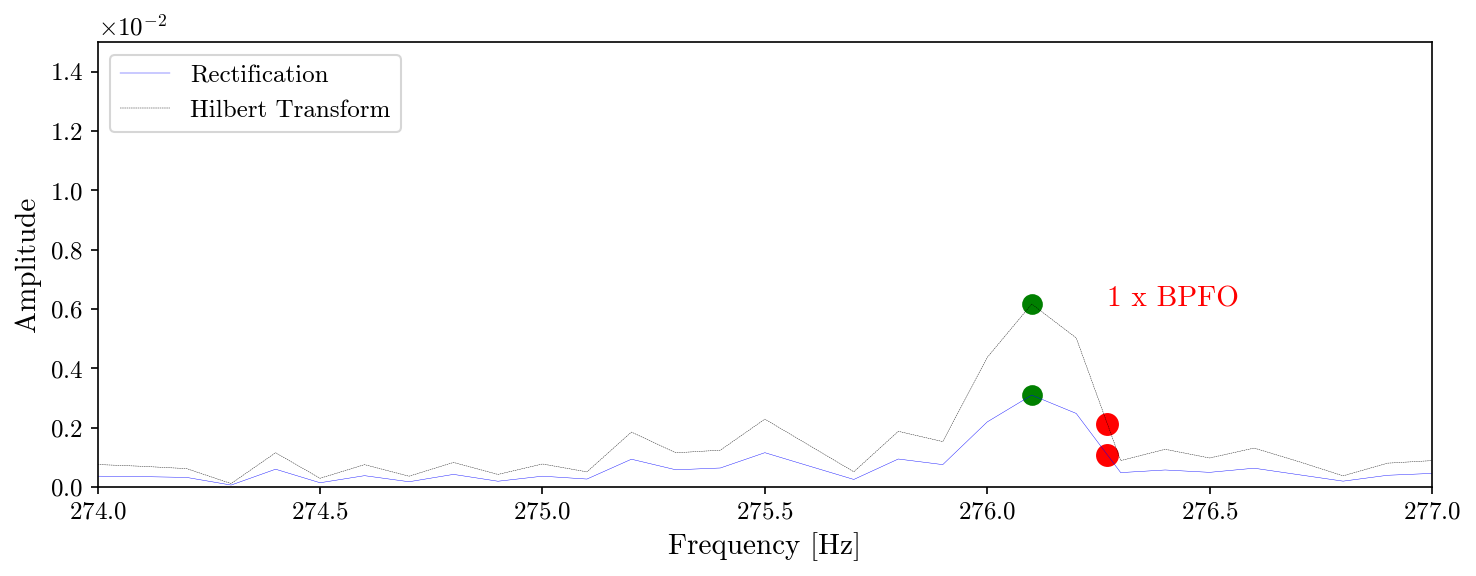

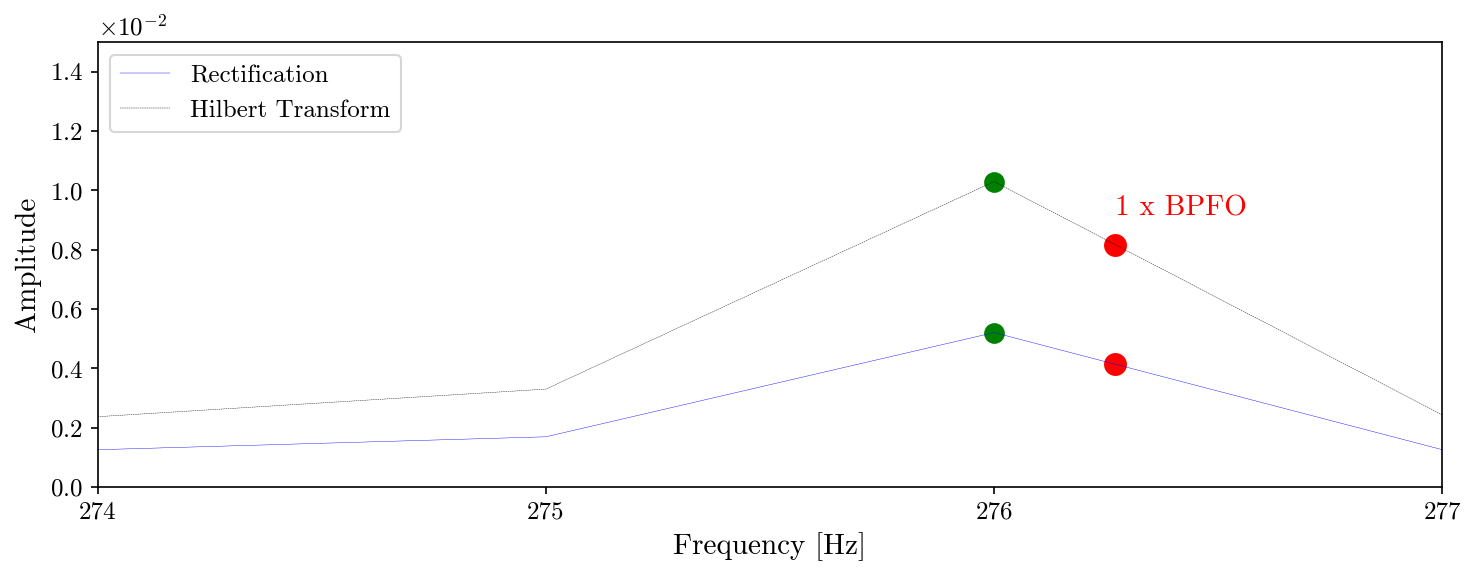

In [16]:

zoomed_min = 274 #bpfo -2
zoomed_max = 277 # + 2

# --- FULL SIGNAL ---
mask_full = (freq_full >= zoomed_min) & (freq_full <= zoomed_max)
freq_zoom_full = freq_full[mask_full]
ses1_zoom_full = ses1[mask_full]
ses1_hilbert_zoom_full = ses1_hilbert[mask_full]

fig_full, ax_full = plt.subplots(figsize=(10, 4))
ax_full.plot(freq_zoom_full, ses1_zoom_full, label="Rectification", color="blue")
ax_full.plot(freq_zoom_full, ses1_hilbert_zoom_full, label="Hilbert Transform", color="black", linestyle="dashed")

for idx, amp in zip(idx1, ses_idx1):
    f_peak = freq_full[idx]
    if zoomed_min <= f_peak <= zoomed_max:
        ax_full.scatter(f_peak, amp, s=80, color="green")

for idx, amp in zip(idx1_hilbert, ses_idx1_hilbert):
    f_peak = freq_full[idx]
    if zoomed_min <= f_peak <= zoomed_max:
        ax_full.scatter(f_peak, amp, s=80, color="green")

y_rect_f = np.interp(bpfo, freq_zoom_full, ses1_zoom_full)
y_hilb_f = np.interp(bpfo, freq_zoom_full, ses1_hilbert_zoom_full)
ax_full.scatter(bpfo, y_rect_f, s=100, color="red")
ax_full.scatter(bpfo, y_hilb_f, s=100, color="red")

ax_full.set_xlim(zoomed_min, zoomed_max)
for i, f in enumerate(bpfo_list[:2]):
    if zoomed_min <= f <= zoomed_max:
        y_interp = np.interp(f, freq_zoom_full, ses1_zoom_full)
        label = f"{i+1} x BPFO"
        ax_full.text(f, y_interp + 0.005, label, color="red", fontsize=14)

ax_full.set_xlabel("Frequency [Hz]")
ax_full.set_ylabel("Amplitude")
ax_full.legend(loc="upper left")
ax_full.set_ylim(0, 0.015)
ax_full.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_full.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.tight_layout()
plt.show()

# --- SEGMENTED SIGNAL ---
mask_seg = (freq_seg >= zoomed_min) & (freq_seg <= zoomed_max)
freq_zoom_seg = freq_seg[mask_seg]
ses1_zoom_seg = ses1_seg[mask_seg]
ses1_hilbert_zoom_seg = ses1_seg_hilbert[mask_seg]

fig_seg, ax_seg = plt.subplots(figsize=(10, 4))
ax_seg.plot(freq_zoom_seg, ses1_zoom_seg, label="Rectification", color="blue")
ax_seg.plot(freq_zoom_seg, ses1_hilbert_zoom_seg, label="Hilbert Transform", color="black", linestyle="dashed")

for idx, amp in zip(idx1_seg, ses_idx1_seg):
    f_peak = freq_seg[idx]
    if zoomed_min <= f_peak <= zoomed_max:
        ax_seg.scatter(f_peak, amp, s=80, color="green")

for idx, amp in zip(idx1_seg_hilbert, ses_idx1_seg_hilbert):
    f_peak = freq_seg[idx]
    if zoomed_min <= f_peak <= zoomed_max:
        ax_seg.scatter(f_peak, amp, s=80, color="green")

y_rect = np.interp(bpfo, freq_zoom_seg, ses1_zoom_seg)
y_hilb = np.interp(bpfo, freq_zoom_seg, ses1_hilbert_zoom_seg)
ax_seg.scatter(bpfo, y_rect, s=100, color="red")
ax_seg.scatter(bpfo, y_hilb, s=100, color="red")

ax_seg.set_xlim(zoomed_min, zoomed_max)
for i, f in enumerate(bpfo_list[:2]):
    if zoomed_min <= f <= zoomed_max:
        y_interp = np.interp(f, freq_zoom_seg, ses1_zoom_seg)
        label = f"{i+1} x BPFO"
        ax_seg.text(f, y_interp + 0.005, label, color="red", fontsize=14)

ax_seg.set_xlabel("Frequency [Hz]")
ax_seg.set_ylabel("Amplitude")
ax_seg.legend(loc="upper left")
ax_seg.set_ylim(0, 0.015)
ax_seg.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_seg.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax_seg.xaxis.set_major_formatter(FormatStrFormatter("%d"))

ax_seg.set_xlim(zoomed_min, zoomed_max)
ax_seg.set_xticks(np.arange(zoomed_min, zoomed_max + 1, 1))
ax_seg.xaxis.set_major_formatter(FormatStrFormatter("%d"))


plt.tight_layout()
plt.show()


## 6. NFFT study: 1x and 2x BPFO amplitude vs NFFT

In [19]:
# # Define NFFT values as powers of 2
p_type = 'SES'
nfft_values = [2**i for i in range(15, 24)]  # 2^15 .. 2^23
exp_sig = [Raw_signal, Raw_signal]   # two copies of same signal

exp_results_full, exp_results_seg, exp_bpfo_list = analyse_ses(
    y_cases=exp_sig,
    fs=fs,
    segment_sec=1,
    bpfo_list=bpfo_list,
    nfft_values=nfft_values,
    p_type=p_type,
    no_case=1, 
    bw=5, # you only want to use the first case
    p_spect=1,
    band=True,
    start_index=0,    # <<< IMPORTANT: no +2 offset for experimental
)

print("NFFT analysis complete.")



NFFT analysis complete.


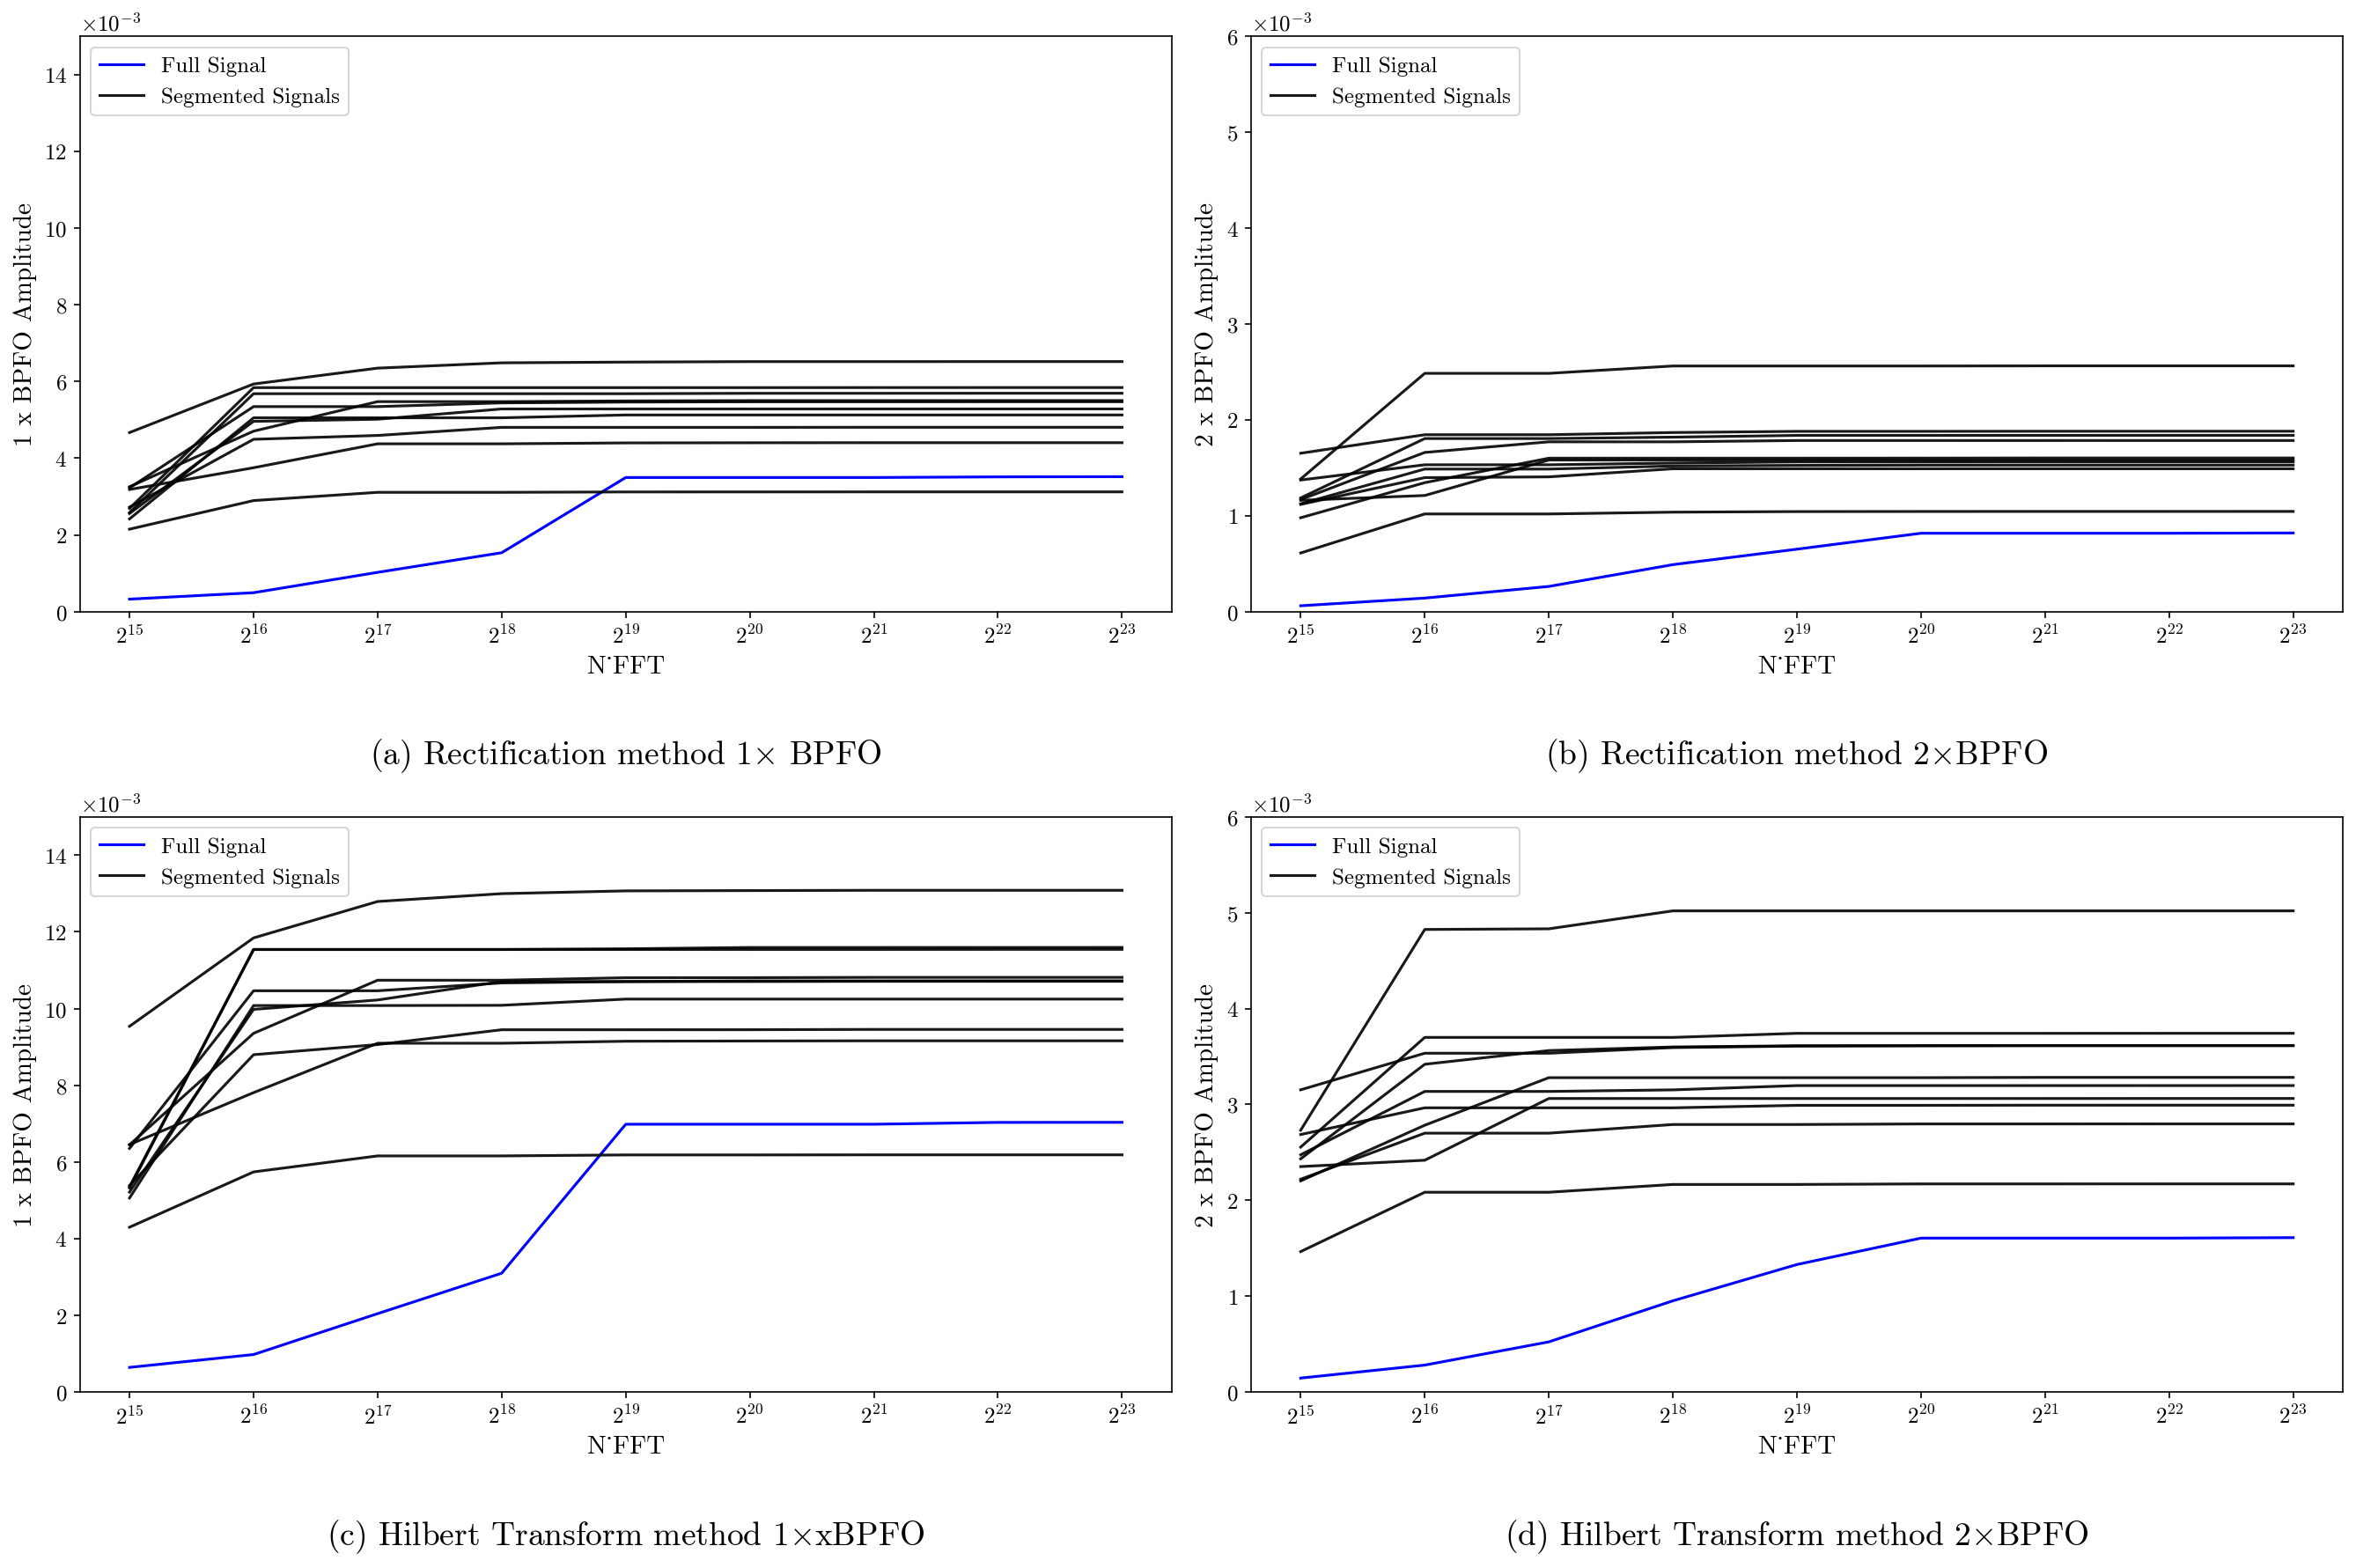

In [21]:

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, -3))
formatter.set_scientific(True)

log2_nfft = [int(np.log2(n)) for n in nfft_values]
x_ticks = [f"$2^{{{i}}}$" for i in log2_nfft]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
methods = ["rect", "hilbert"]

for row, method in enumerate(methods):
    peak_matrix_full = exp_results_full[method][0]  # case 0
    peak_matrix_seg = exp_results_seg[method][0]

    for col in range(2):
        ax = axes[row, col]
        harm = col + 1  # 1x or 2x BPFO

        ax.plot(
            peak_matrix_full[harm - 1, :],
            label="Full Signal",
            linewidth=1.5,
            color="blue",
        )

        for j, seg_curve in enumerate(peak_matrix_seg[harm - 1]):
            label = "Segmented Signals" if j == 0 else None
            ax.plot(
                seg_curve,
                color="black",
                alpha=0.9,
                linewidth=1.5,
                label=label,
            )

        ax.set_xticks(np.arange(len(x_ticks)))
        ax.set_xticklabels(x_ticks)
        ax.set_ylabel(f"{harm} x BPFO Amplitude")
        ax.set_xlabel("N_FFT")
        ax.yaxis.set_major_formatter(formatter)

        if harm == 1:
            ax.set_ylim(0, 0.015)
        else:
            ax.set_ylim(0, 0.006)

        ax.legend(loc="upper left")

labels = [
    r"(a) Rectification method 1$\times$ BPFO",
   r"(b) Rectification method 2$\times$BPFO",
    r"(c) Hilbert Transform method 1$\times$xBPFO",
    r"(d) Hilbert Transform method 2$\times$BPFO",
]

for idx, txt in enumerate(labels):
    axes.flatten()[idx].text(
        0.5,
        -0.25,
        txt,
        ha="center",
        va="center",
        transform=axes.flatten()[idx].transAxes,
        fontsize=18,
    )

plt.tight_layout()
plt.show()


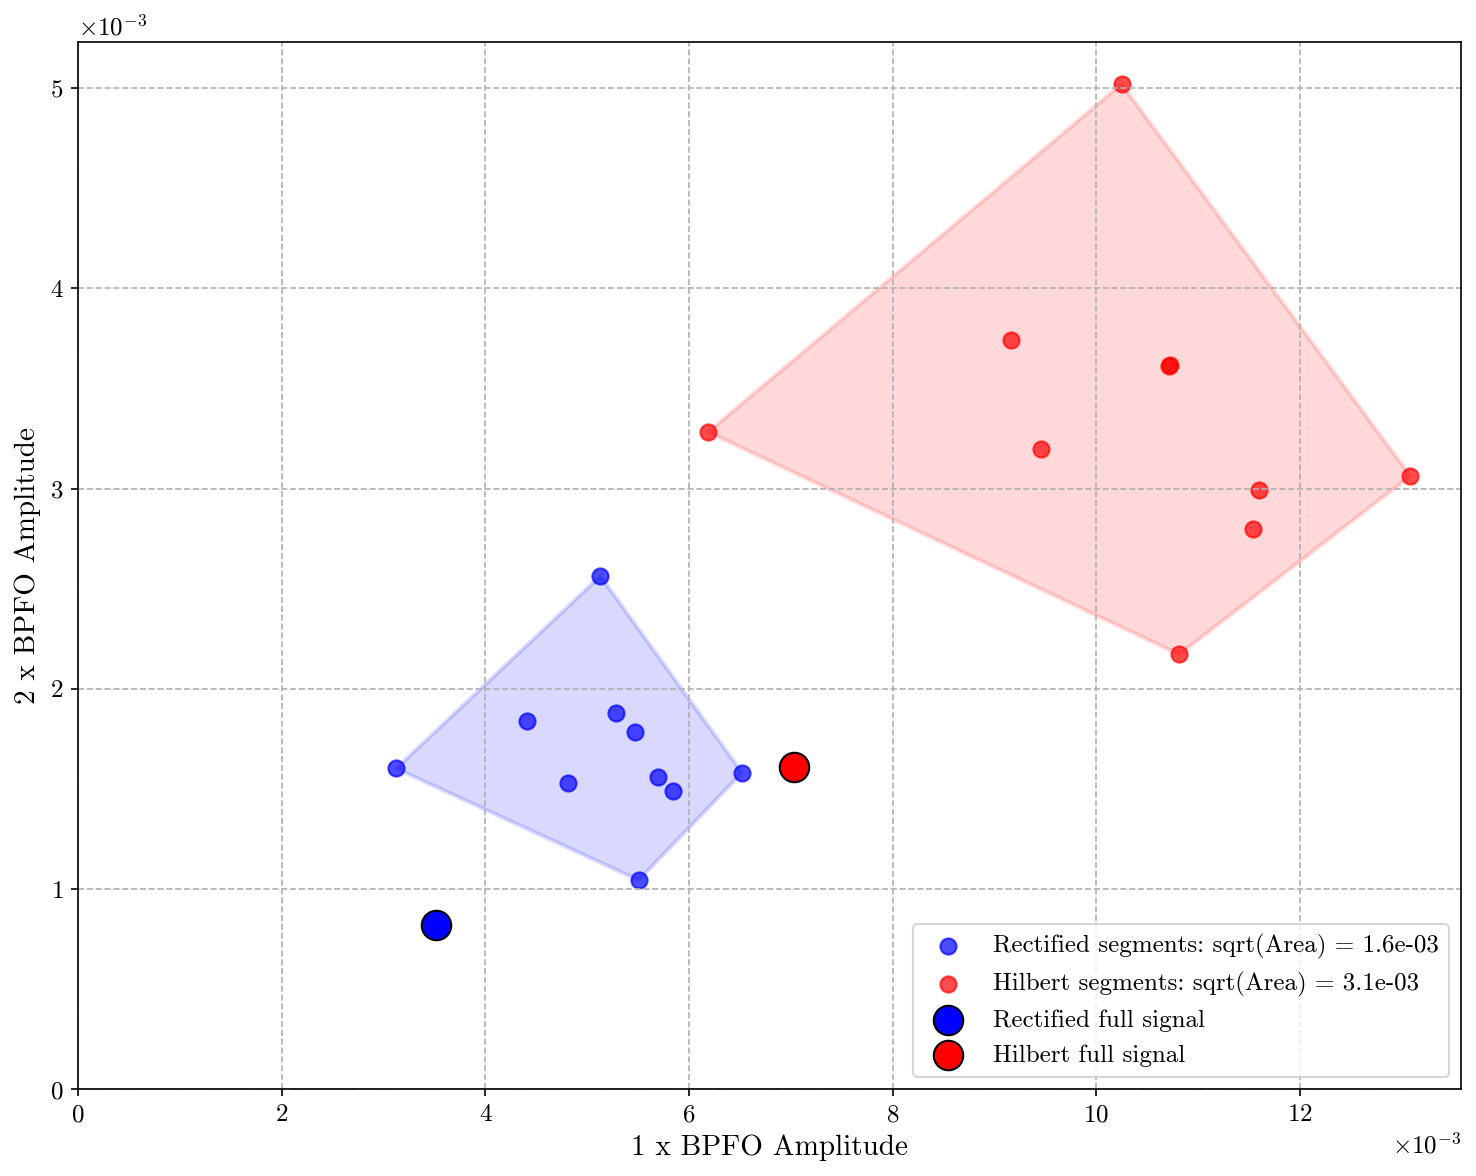

In [23]:

# Choose which NFFT exponent to visualise (must be in log2_nfft)
target_exponent = 23
if target_exponent not in log2_nfft:
    raise ValueError(f"NFFT exponent {target_exponent} not in nfft_values.")

target_idx = log2_nfft.index(target_exponent)
case_idx = 0

# Full signal values
exp_rect_full_1x = exp_results_full["rect"][case_idx][0, target_idx]
exp_rect_full_2x = exp_results_full["rect"][case_idx][1, target_idx]
exp_hilb_full_1x = exp_results_full["hilbert"][case_idx][0, target_idx]
exp_hilb_full_2x = exp_results_full["hilbert"][case_idx][1, target_idx]

# Segmented values
exp_rect_seg_1x = [
    exp_results_seg["rect"][case_idx][0][i][target_idx]
    for i in range(len(exp_results_seg["rect"][case_idx][0]))
]
exp_rect_seg_2x = [
    exp_results_seg["rect"][case_idx][1][i][target_idx]
    for i in range(len(exp_results_seg["rect"][case_idx][1]))
]
exp_hilb_seg_1x = [
    exp_results_seg["hilbert"][case_idx][0][i][target_idx]
    for i in range(len(exp_results_seg["hilbert"][case_idx][0]))
]
exp_hilb_seg_2x = [
    exp_results_seg["hilbert"][case_idx][1][i][target_idx]
    for i in range(len(exp_results_seg["hilbert"][case_idx][1]))
]

exp_rect_points = np.column_stack((exp_rect_seg_1x, exp_rect_seg_2x))
exp_hilb_points = np.column_stack((exp_hilb_seg_1x, exp_hilb_seg_2x))

fig, ax = plt.subplots(figsize=(10, 8))

exp_area_rect = convexhull(exp_rect_points, color="blue", ax=ax)
exp_area_hilb = convexhull(exp_hilb_points, color="red", ax=ax)

def format_sqrt_area(val: float) -> str:
    return f"{val:.1e}"

exp_area_rect_str = format_sqrt_area(exp_area_rect)
exp_area_hilb_str = format_sqrt_area(exp_area_hilb)

ax.scatter(
    exp_rect_seg_1x,
    exp_rect_seg_2x,
    color="blue",
    s=60,
    alpha=0.7,
    label=f"Rectified segments: sqrt(Area) = {exp_area_rect_str}",
)
ax.scatter(
    exp_hilb_seg_1x,
    exp_hilb_seg_2x,
    color="red",
    s=60,
    alpha=0.7,
    label=f"Hilbert segments: sqrt(Area) = {exp_area_hilb_str}",
)

ax.scatter(
    exp_rect_full_1x,
    exp_rect_full_2x,
    color="blue",
    s=200,
    edgecolor="black",
    label="Rectified full signal",
)
ax.scatter(
    exp_hilb_full_1x,
    exp_hilb_full_2x,
    color="red",
    s=200,
    edgecolor="black",
    label="Hilbert full signal",
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, -3))
formatter.set_scientific(True)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel("1 x BPFO Amplitude")
ax.set_ylabel("2 x BPFO Amplitude")
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.legend(loc="lower right")
ax.grid(True)
plt.tight_layout()
plt.show()


## 8. NFFT equivalence demonstration

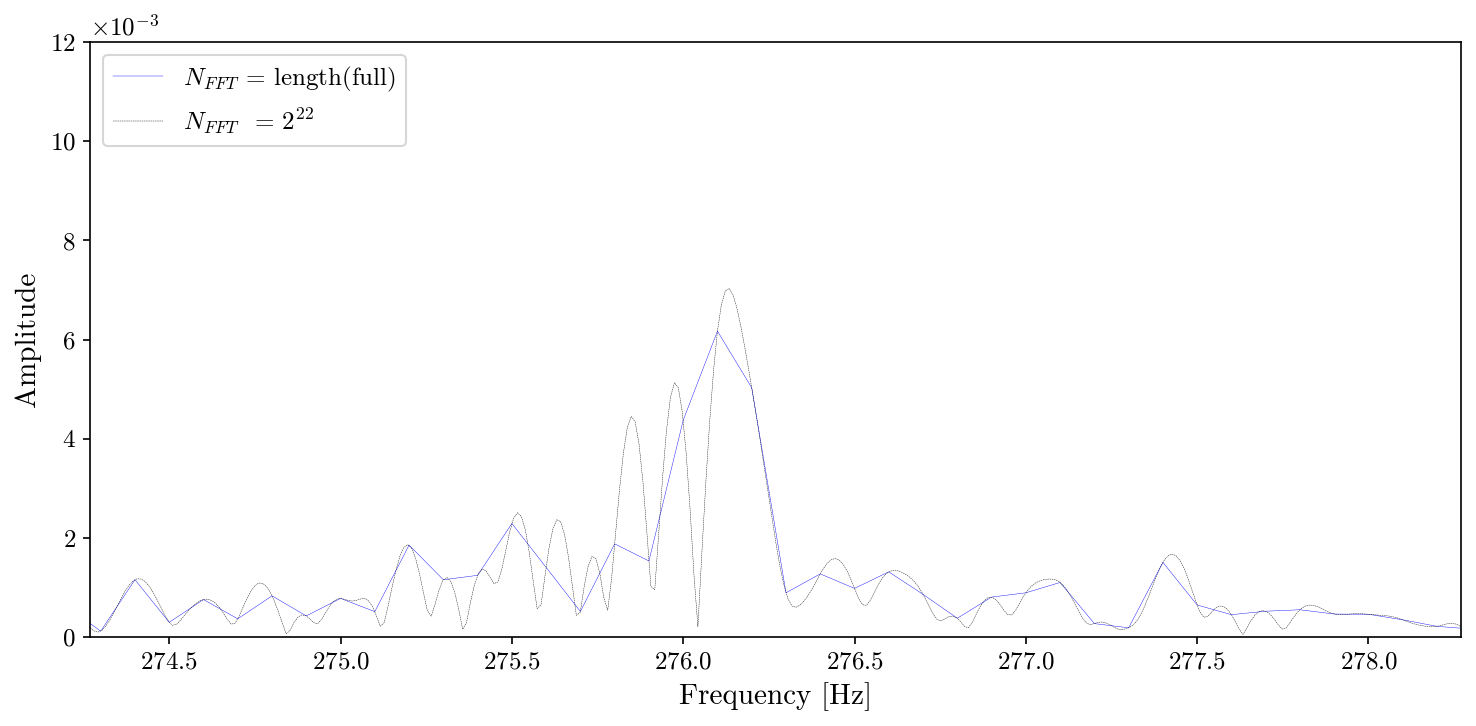

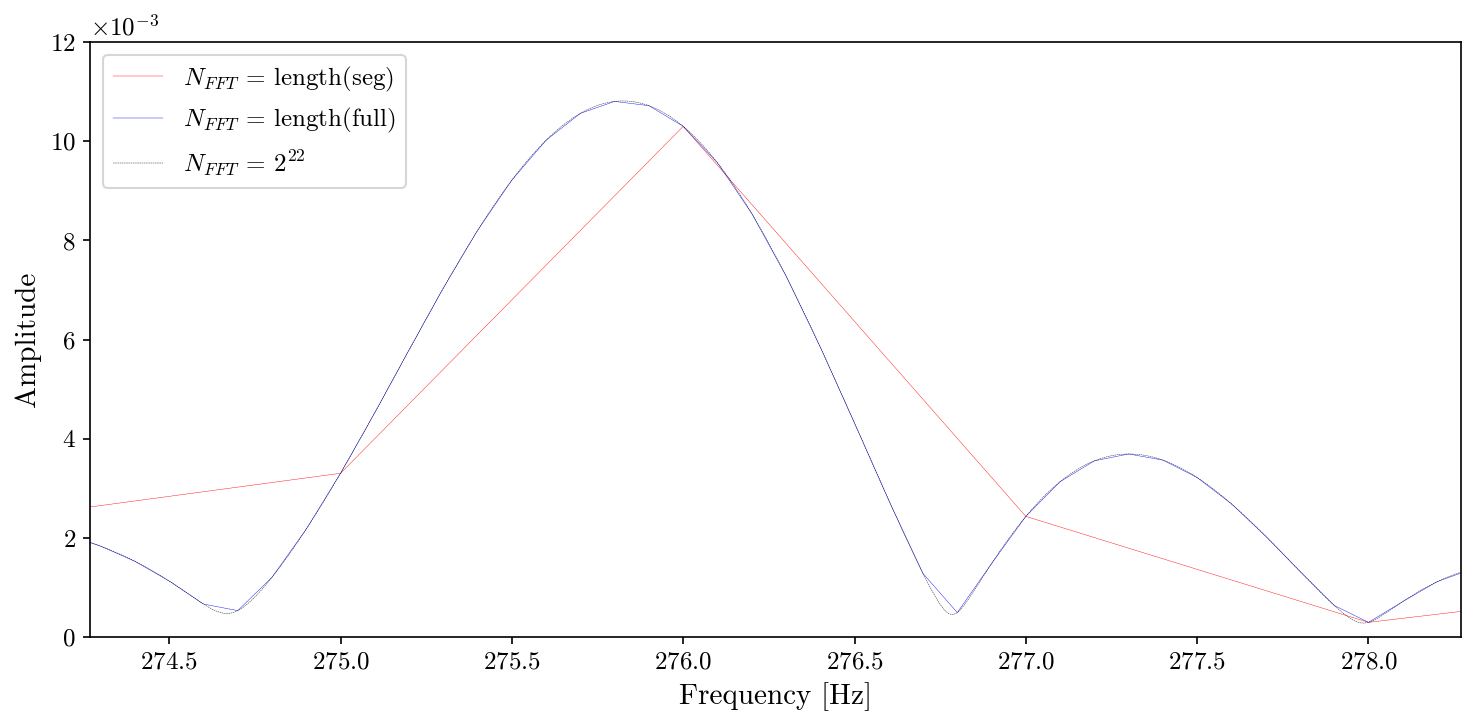

In [25]:

index = 22  # exponent for 2^index
nfft_seg_same_len = len(y1_seg)
nfft_seg_signal_len = len(y1)
nfft_full = len(y1)
nfft_ful_2_index = 2**index

freq_seg_same_len = np.arange(nfft_seg_same_len // 2) * (fs / nfft_seg_same_len)
freq_signal_len = np.arange(nfft_full // 2) * (fs / nfft_full)
freq_2_index = np.arange(nfft_ful_2_index // 2) * (fs / nfft_ful_2_index)

p_type = "SES"
ses_idx_full_len, idx_full_len, ses_full_len = ses(y1, nfft_full, fs, bpfo_list, hilb="t", p_type=p_type,bw=5, band=True)
ses_idx_full_2p, idx_full_2p, ses_full_2p = ses(y1, nfft_ful_2_index, fs, bpfo_list, hilb="t", p_type=p_type,bw=5, band=True)

ses_idx_seg_same, idx_seg_same, ses_seg_same = ses(y1_seg, nfft_seg_same_len, fs, bpfo_list, hilb="t", p_type=p_type,bw=5, band=True)
ses_idx_seg_signal_len, idx_seg_signal_len, ses_seg_signal_len = ses(y1_seg, nfft_seg_signal_len, fs, bpfo_list, hilb="t", p_type=p_type,bw=5, band=True)
ses_idx_seg_2p, idx_seg_2p, ses_seg_2p = ses(y1_seg, nfft_ful_2_index, fs, bpfo_list, hilb="t", p_type=p_type,bw=5, band=True)

zoom_min, zoom_max = bpfo - 2, bpfo + 2

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, -3))
formatter.set_scientific(True)

fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(freq_signal_len, ses_full_len[: len(freq_signal_len)], label=fr"$N_{{FFT}}$ = length(full)", color="blue")
ax1.plot(freq_2_index, ses_full_2p[: len(freq_2_index)], label=fr"$N_{{FFT}}$  = $2^{{{index}}}$", color="black", linestyle="dashed")
ax1.set_xlim(zoom_min, zoom_max)
ax1.set_ylim(0, 0.012)
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Amplitude")
ax1.yaxis.set_major_formatter(formatter)
ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(freq_seg_same_len, ses_seg_same[: len(freq_seg_same_len)], label=fr"$N_{{FFT}}$ = length(seg)", color="red")
ax2.plot(freq_signal_len, ses_seg_signal_len[: len(freq_signal_len)], label=fr"$N_{{FFT}}$ = length(full)", color="blue")
ax2.plot(freq_2_index, ses_seg_2p[: len(freq_2_index)], label=fr"$N_{{FFT}}$ = $2^{{{index}}}$", color="black", linestyle="dashed")
ax2.set_xlim(zoom_min, zoom_max)
ax2.set_ylim(0, 0.012)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Amplitude")
ax2.yaxis.set_major_formatter(formatter)
ax2.legend(loc="upper left")
plt.tight_layout()
plt.show()
